In [1]:
library(brms) #predictability: Double hierarchical model
library(MCMCglmm) #HPDinterval
library(dplyr) #%>%

Warning message:
"le package 'brms' a été compilé avec la version R 4.1.2"
Le chargement a nécessité le package : Rcpp

Warning message:
"le package 'Rcpp' a été compilé avec la version R 4.1.2"
Loading 'brms' package (version 2.16.3). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attachement du package : 'brms'


L'objet suivant est masqué depuis 'package:stats':

    ar


Warning message:
"le package 'MCMCglmm' a été compilé avec la version R 4.1.2"
Le chargement a nécessité le package : Matrix

Warning message:
"le package 'Matrix' a été compilé avec la version R 4.1.2"
Le chargement a nécessité le package : coda

Warning message:
"le package 'coda' a été compilé avec la version R 4.1.2"
Le chargement a nécessité le package : ape

Warning message:
"le package 'ape' a été compilé avec la version R 4.1.2"

Attachement du package : 'MCMCglmm'


L'objet suivant est masqué depuis 'pac

In [2]:
#install.packages("dplyr")

In [3]:
#citation("merTools")

In [4]:
library(parallel)
my.cores = detectCores()

# Download data

In [5]:
path_ = 'G:/VPHI/Welfare/2- Research Projects/OFHE2.OriginsE2/DataOutput/TrackingSystem/ALLDATA_'
path_adapt = file.path(path_,'Adaptability')
df = read.csv(file.path(path_adapt,'df_MVT_4individuality_withPCA.csv'), header = TRUE, sep = ",")
df$HenID = as.factor(df$HenID)   
df$PenID = as.factor(df$PenID) 
df$cDIB = as.integer(df$DIB_startat11)
df$CLASS = as.factor(df$CLASS) 
df$Treatment = as.factor(df$Treatment)
#scale: mean-centering of the environmental variable so that intercepts reflect average values for the population and ind. 
df$temperature_C_avg_scale = scale(df$temperature_C_avg, center=TRUE, scale=TRUE)
df$time = scale(df$cDIB, center=FALSE, scale=TRUE)
df$time = scale(df$cDIB, center=FALSE, scale=sd(df$cDIB, na.rm = TRUE)) #as not centering, we need to add this
df$time2 = poly(df$time, degree=2, raw=TRUE)[,2]
df$avgDIB_scale = scale(df$avgDIB, center=TRUE, scale=TRUE)
df$InitialWeight_scale = scale(df$InitialWeight, center=TRUE, scale=TRUE)

#setting reference group
contrasts(df$Treatment)
df <- df %>% mutate(Treatment = relevel(Treatment, ref = "TRAN"))
contrasts(df$Treatment)

contrasts(df$CLASS)
df <- df %>% mutate(CLASS = relevel(CLASS, ref = "LEXP"))
contrasts(df$CLASS)

print(dim(df))
summary(df)

,TRAN
OFH,0
TRAN,1


,OFH
TRAN,0
OFH,1


,MEXP,REXP
LEXP,0,0
MEXP,1,0
REXP,0,1


,MEXP,REXP
LEXP,0,0
MEXP,1,0
REXP,0,1


[1] 3230   32


     HenID           DIB         CLASS          PenID     temperature_C_avg
 hen_116:  43   Min.   :11.00   LEXP: 965   pen10  :504   Min.   : 4.000   
 hen_124:  43   1st Qu.:23.00   MEXP:1379   pen11  :504   1st Qu.: 8.667   
 hen_127:  43   Median :33.00   REXP: 886   pen8   :430   Median :11.000   
 hen_136:  43   Mean   :33.59               pen9   :429   Mean   :10.838   
 hen_147:  43   3rd Qu.:44.00               pen4   :388   3rd Qu.:12.667   
 hen_151:  43   Max.   :54.00               pen5   :363   Max.   :19.333   
 (Other):2972                               (Other):612                    
  tobeusedPCA     InitialWeight  Treatment   perc_duration_5_Zone
 Min.   :0.0000   Min.   :1046   TRAN:1616   Min.   :  0.00      
 1st Qu.:0.0000   1st Qu.:1130   OFH :1614   1st Qu.: 11.00      
 Median :0.0000   Median :1164               Median : 33.00      
 Mean   :0.1734   Mean   :1169               Mean   : 39.21      
 3rd Qu.:0.0000   3rd Qu.:1200               3rd Qu.: 66.00   

In [6]:
sd(df$temperature_C_avg_scale)

[1] 1

In [7]:
length(unique(df[['HenID']]))

[1] 80

# Predictibility

In [8]:
#Get information on all parameters (and parameter classes) for which priors may be specified including default priors:
get_prior(formula= PC1~ time + time2 + Treatment + temperature_C_avg_scale + (1+ time + time2|HenID), 
          data=df, family = gaussian())

prior,class,coef,group,resp,dpar,nlpar,bound,source
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
,b,,,,,,,default
,b,temperature_C_avg_scale,,,,,,default
,b,time,,,,,,default
,b,time2,,,,,,default
,b,TreatmentOFH,,,,,,default
lkj(1),cor,,,,,,,default
,cor,,HenID,,,,,default
"student_t(3, 0.3, 2.5)",Intercept,,,,,,,default
"student_t(3, 0, 2.5)",sd,,,,,,,default


Compiling Stan program...

Start sampling

Warning message:
"
125 (3.9%) p_waic estimates greater than 0.4. We recommend trying loo instead."
Warning message:
"Found 4 observations with a pareto_k > 0.7 in model 'modelPred'. It is recommended to set 'moment_match = TRUE' in order to perform moment matching for problematic observations. "


 Family: gaussian 
  Links: mu = identity; sigma = log 
Formula: PC1 ~ time + time2 + Treatment + temperature_C_avg_scale + (1 + time + time2 | a | HenID) 
         sigma ~ time + time2 + Treatment + temperature_C_avg_scale + (1 | a | HenID)
   Data: df (Number of observations: 3230) 
  Draws: 10 chains, each with iter = 16668; warmup = 8334; thin = 3;
         total post-warmup draws = 27780

Group-Level Effects: 
~HenID (Number of levels: 80) 
                               Estimate Est.Error l-95% CI u-95% CI Rhat
sd(Intercept)                      1.14      0.10     0.97     1.35 1.00
sd(time)                           0.91      0.08     0.76     1.09 1.00
sd(time2)                          0.20      0.02     0.17     0.25 1.00
sd(sigma_Intercept)                0.24      0.03     0.20     0.30 1.00
cor(Intercept,time)               -0.69      0.06    -0.80    -0.55 1.00
cor(Intercept,time2)               0.42      0.10     0.21     0.60 1.00
cor(time,time2)                   -0.90

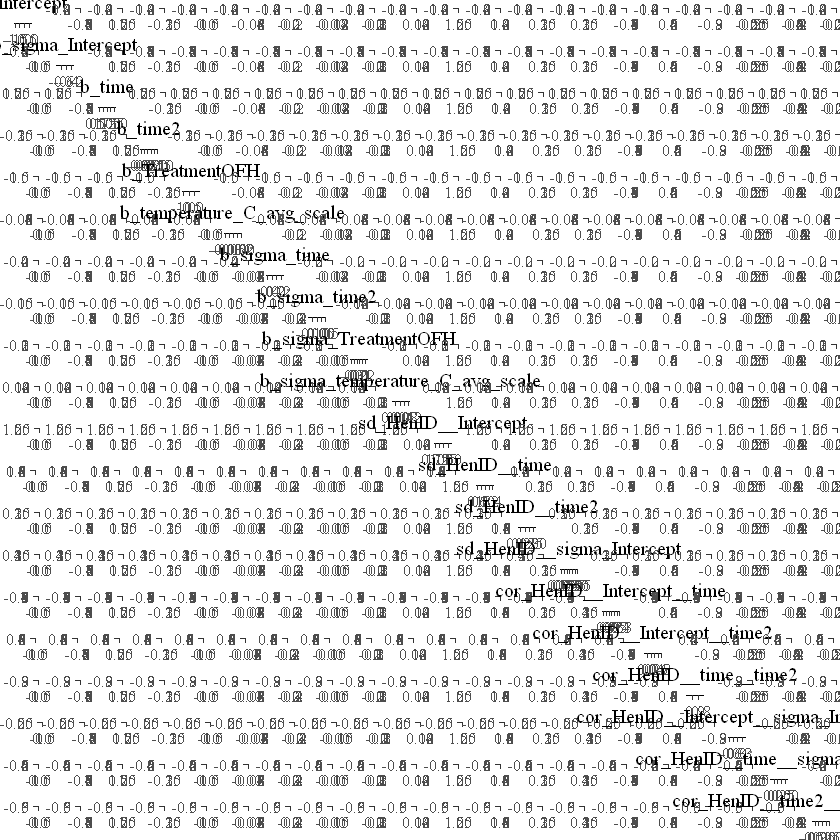

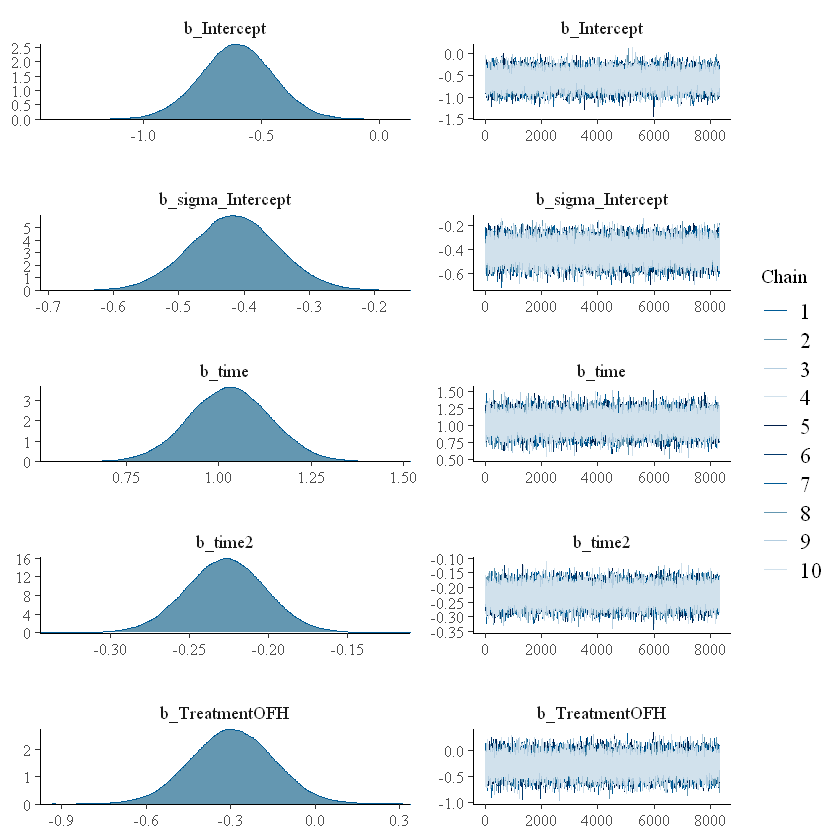

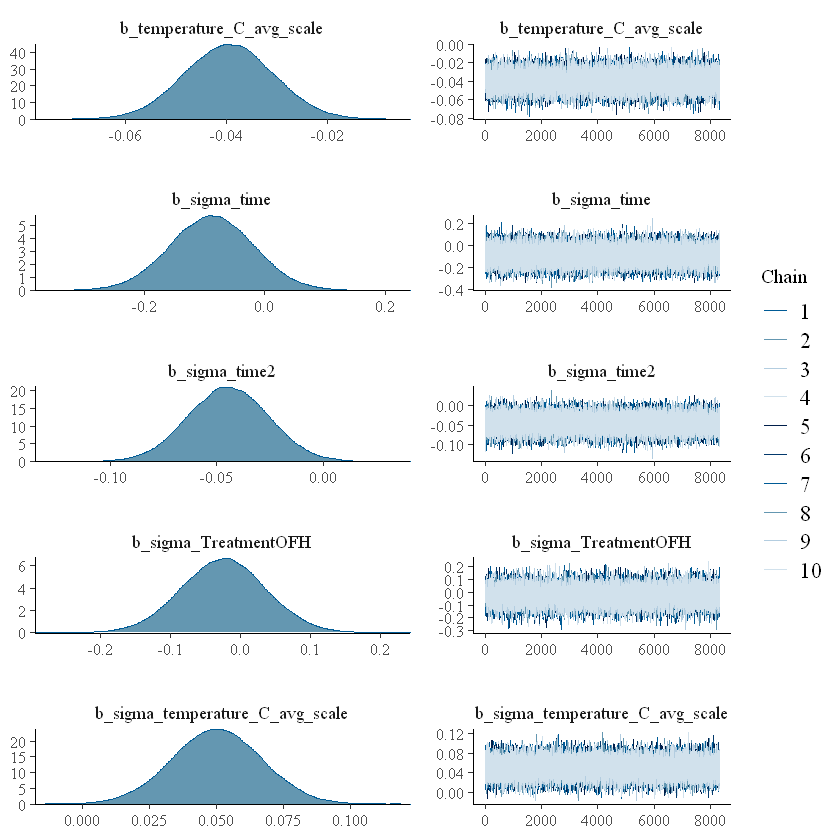

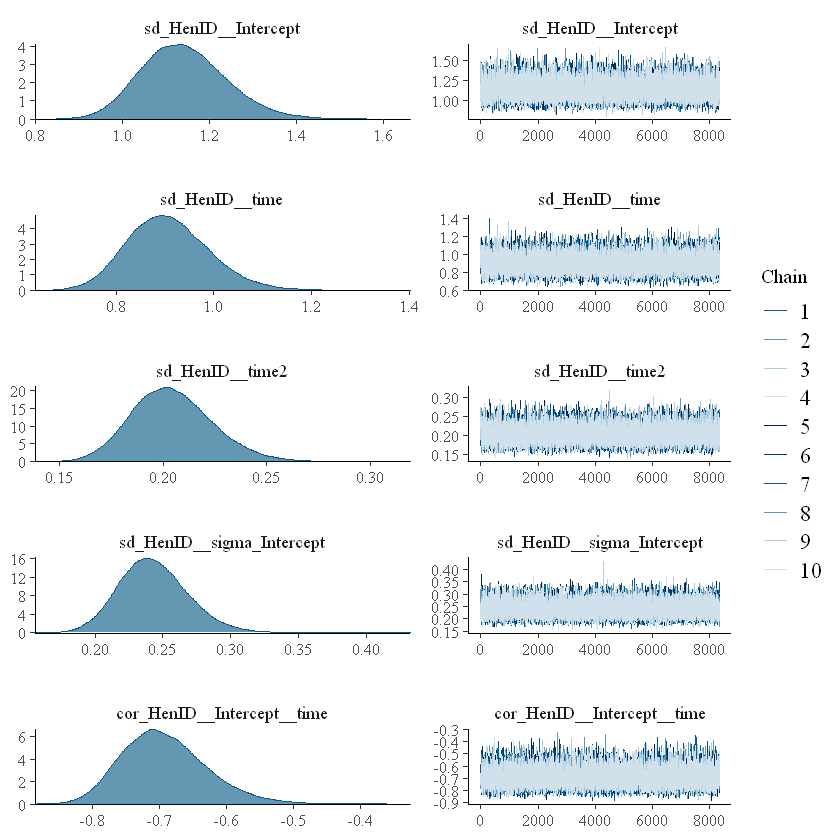

Warning message:
"Method 'posterior_samples' is deprecated. Please see ?as_draws for recommended alternatives."


[1] 0.246929

,lower,upper
var1,0.1955119,0.2991971


prior,class,coef,group,resp,dpar,nlpar,bound,source
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
,b,,,,,,,default
,b,temperature_C_avg_scale,,,,,,default
,b,time,,,,,,default
,b,time2,,,,,,default
,b,TreatmentOFH,,,,,,default
,b,,,,sigma,,,default
,b,temperature_C_avg_scale,,,sigma,,,default
,b,time,,,sigma,,,default
,b,time2,,,sigma,,,default


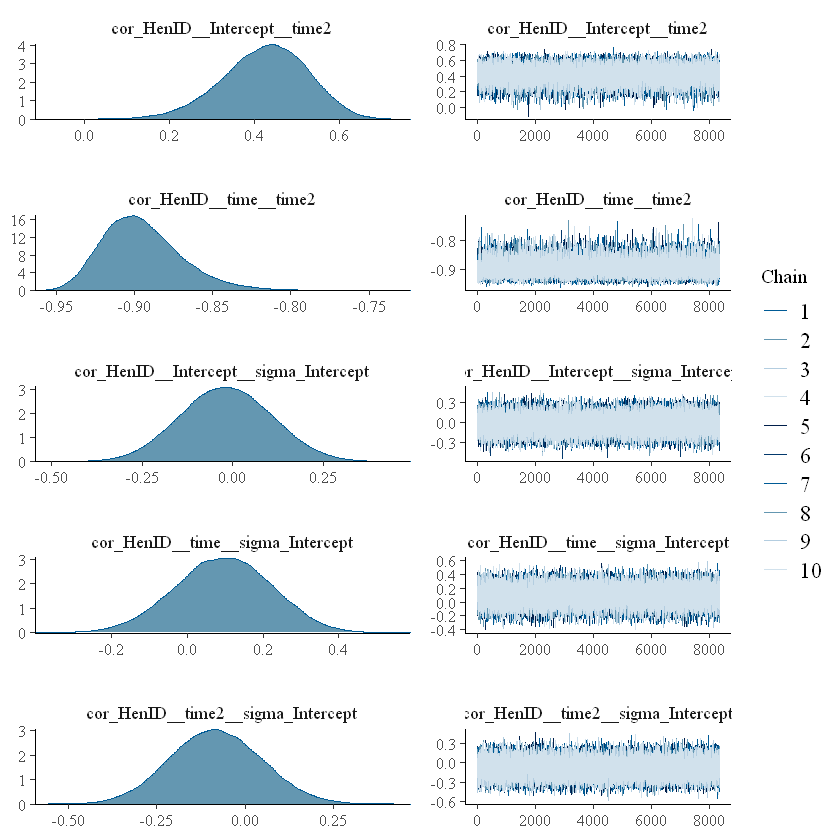

In [9]:
#help(brms) #to cite STAN for the following info:
### bulk-ESS: We recommend requiring that the bulk-ESS is greater than 100 times the number of chains. For example, when running 
#4 chains, this corresponds to having a rank-normalized effective sample size of at least 400.
### R-hat: We recommend running at least four chains by default and only using the sample if R-hat is less than 1.01.
#more info: #https://mc-stan.org/misc/warnings.html #bulk-ess%22
double_model = bf(PC1~ time + time2 + Treatment + temperature_C_avg_scale + (1+time+time2|a|HenID), 
                  sigma~time + time2 + Treatment + temperature_C_avg_scale + (1|a|HenID))
#|a|: from Hertel guide: such a correlation can give insights whether certain behavioral types are particularly predictable or un-predictable in their 
#behavior. We can fit such a correlation by adding a term betweenthe specified random slope and intercept terms in both the 
#mean part oft the model, and the variance part.Below we chose to add the character “|a”, the character can be randomly chosen.
#We  now  find  an  additional  term  “cor(Intercept,sigma_Intercept)”  under  “Group-Level  Effects”:
#“cor(Intercept,sigma_Intercept)” is the term that estimates whether average behavior (behavioraltype) and residual variance 
#(predictability) are correlated. As we can see in the model output, there isa positive correlation between “Intercept” and 
#“sigma_Intercept” which is estimated at 0.5 [0.18, 0.74].Elephants with longer daily travel distances are therefore also less 
#predictable than elephants with shortermovement distances.

#warmup: default iter/2
#algorithm: default: "sampling" for mcmc
modelPred = brm(double_model, data=df, iter=50000, inits="random", seed=12345, control = list(max_treedepth = 15), 
                cores=my.cores, chains=10, thin=3)
#add score and save model
#loo: https://cran.r-project.org/web/packages/loo/ Efficient approximate leave-one-out cross-validation (LOO) for Bayesian 
#models fit using Markov chain Monte Carlo, as described in Vehtari, Gelman, and Gabry (2017) The approximation uses Pareto 
#smoothed importance sampling (PSIS), 
modelPred = add_criterion(modelPred, criterion=c('waic','bayes_R2','loo'), file=file.path(path_adapt,'BRMS_Model_variance0_pred'))

summary(modelPred)
pairs(modelPred)
plot(modelPred)
#head(get_variables(modelPred),10)

#coefficient of variation in predictability” (CVP)
log.norm.res = exp(posterior_samples(modelPred)$"sd_HenID__sigma_Intercept"^2)
CVP = sqrt(log.norm.res-1)
mean(CVP);HPDinterval(as.mcmc(CVP),0.95)

#extract samples (draw) from the posterior distribution, including all variables
#df_pred = posterior_samples(modelPred) #depreciated but still work well. we will instead use:
df_pred = as_draws(modelPred)
write.csv(df_pred, file.path(path_adapt,'BLUPS_variability0_pred.csv'), row.names = FALSE)
prior_summary(modelPred)

In [15]:
#mean population-level residual variance
fixef(modelPred, pars = "sigma_Intercept")[1]

[1] -0.4155517

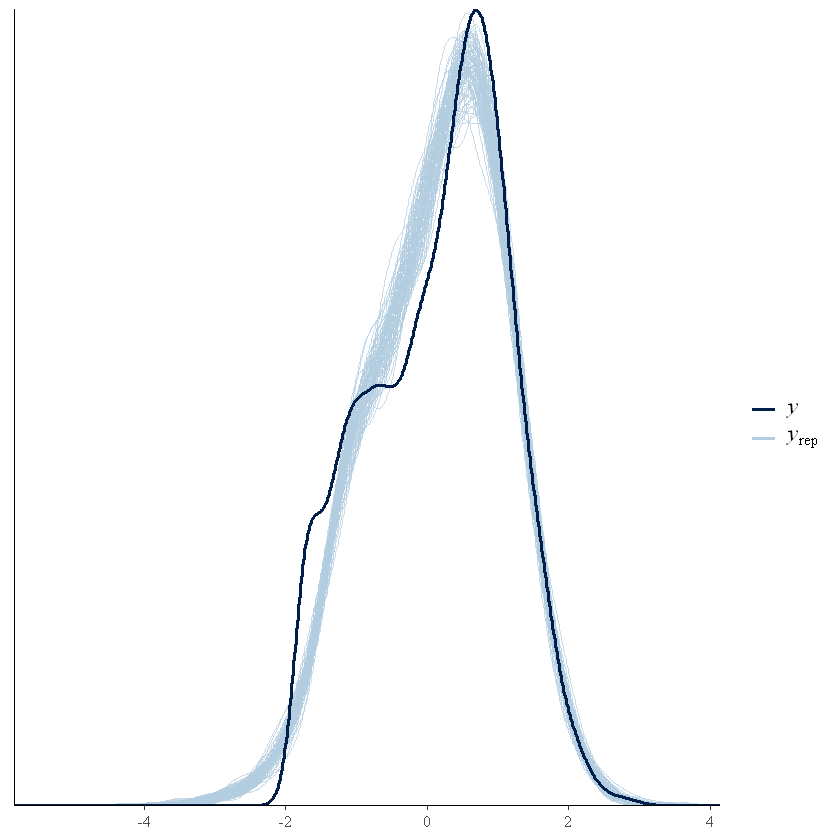

In [16]:
#posterior predictive check
pp_check(modelPred, ndraws = 100)
#-->we don't see any major systematic discrepancies of our data from what can be predicted with modelPred

In [12]:
print(modelPred$criteria$waic)


Computed from 83340 by 3230 log-likelihood matrix

          Estimate   SE
elpd_waic  -2214.4 47.5
p_waic       287.4 10.2
waic        4428.8 95.0

125 (3.9%) p_waic estimates greater than 0.4. We recommend trying loo instead. 


In [13]:
#approximative leave-one-out cross validation
print(modelPred$criteria$loo)


Computed from 83340 by 3230 log-likelihood matrix

         Estimate   SE
elpd_loo  -2223.3 48.0
p_loo       296.3 11.1
looic      4446.6 95.9
------
Monte Carlo SE of elpd_loo is NA.

Pareto k diagnostic values:
                         Count Pct.    Min. n_eff
(-Inf, 0.5]   (good)     3205  99.2%   4673      
 (0.5, 0.7]   (ok)         21   0.7%   728       
   (0.7, 1]   (bad)         4   0.1%   147       
   (1, Inf)   (very bad)    0   0.0%   <NA>      
See help('pareto-k-diagnostic') for details.



Computed from 83340 by 3230 log-likelihood matrix

         Estimate   SE
elpd_loo  -2223.3 48.0
p_loo       296.3 11.1
looic      4446.6 95.9
------
Monte Carlo SE of elpd_loo is NA.

Pareto k diagnostic values:
                         Count Pct.    Min. n_eff
(-Inf, 0.5]   (good)     3205  99.2%   4673      
 (0.5, 0.7]   (ok)         21   0.7%   728       
   (0.7, 1]   (bad)         4   0.1%   147       
   (1, Inf)   (very bad)    0   0.0%   <NA>      
See help('pareto-k-diagnostic') for details.

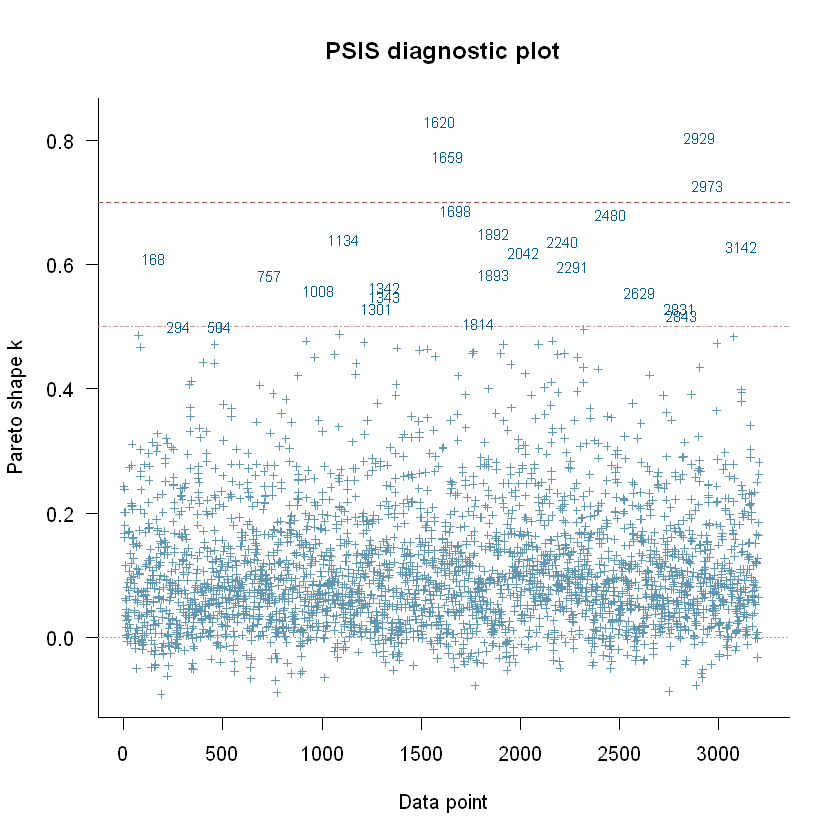

In [14]:
#https://cran.r-project.org/web/packages/loo/vignettes/loo2-moment-matching.html
#https://cran.r-project.org/web/packages/loo/vignettes/loo2-example.html
#"If we had a well-specified model we would expect the estimated effective number of parameters (p_loo) to be smaller than or 
#similar to the total number of parameters in the model. Here p_loo is almost 300, which is about 70 times the total number of 
#parameters in the model, indicating severe model misspecification."
loo2 = loo(modelPred, moment_match = TRUE)
loo2
plot(loo2, label_points = TRUE)

## compare without sigma part

Compiling Stan program...

Start sampling

Warning message:
"
92 (2.8%) p_waic estimates greater than 0.4. We recommend trying loo instead."
Warning message:
"Found 2 observations with a pareto_k > 0.7 in model 'modelPred2'. It is recommended to set 'moment_match = TRUE' in order to perform moment matching for problematic observations. "


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: PC1 ~ time + time2 + Treatment + temperature_C_avg_scale + (1 + time + time2 | HenID) 
   Data: df (Number of observations: 3230) 
  Draws: 10 chains, each with iter = 16668; warmup = 8334; thin = 3;
         total post-warmup draws = 27780

Group-Level Effects: 
~HenID (Number of levels: 80) 
                     Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sd(Intercept)            1.11      0.09     0.94     1.31 1.00    47932
sd(time)                 0.89      0.08     0.74     1.06 1.00    45240
sd(time2)                0.22      0.02     0.18     0.26 1.00    45421
cor(Intercept,time)     -0.65      0.07    -0.77    -0.51 1.00    46753
cor(Intercept,time2)     0.36      0.11     0.13     0.55 1.00    44117
cor(time,time2)         -0.88      0.03    -0.93    -0.82 1.00    44246
                     Tail_ESS
sd(Intercept)           65579
sd(time)                62341
sd(time2)               63005
cor(Interce

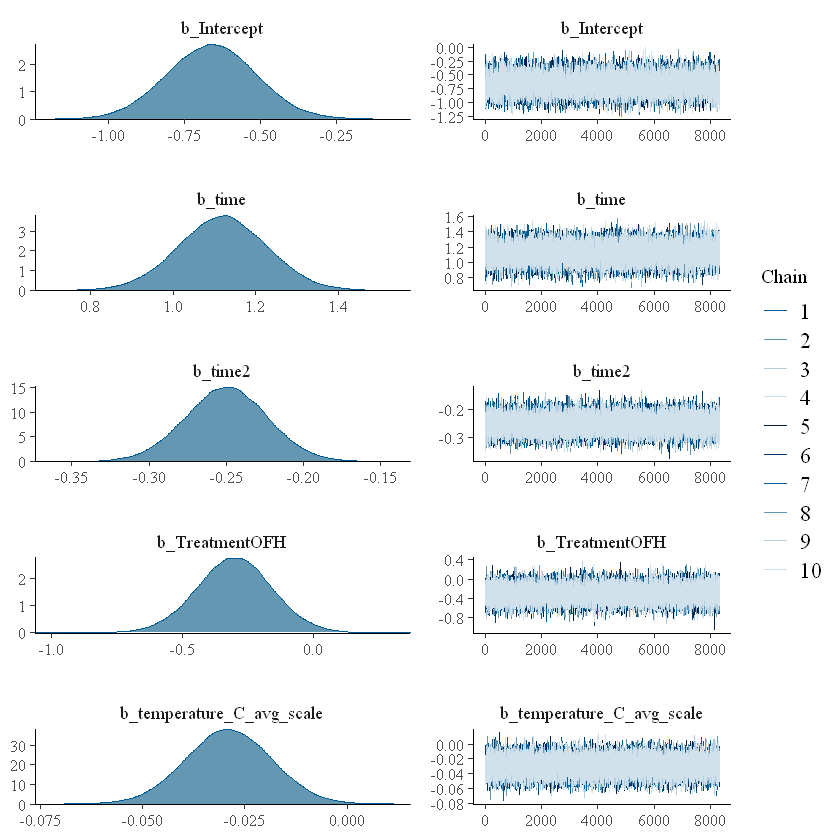

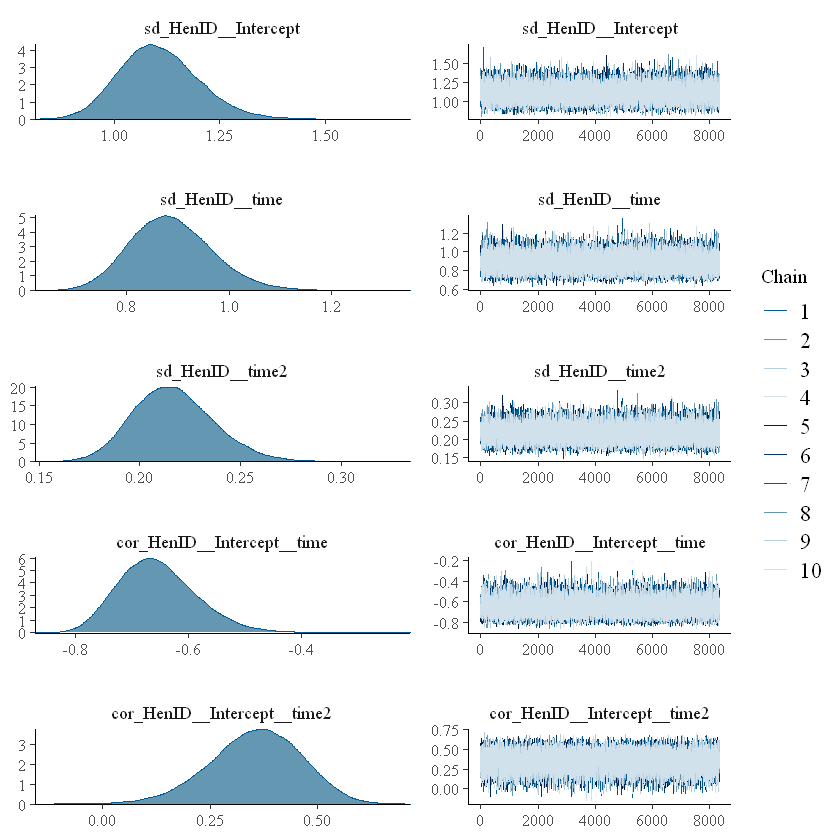

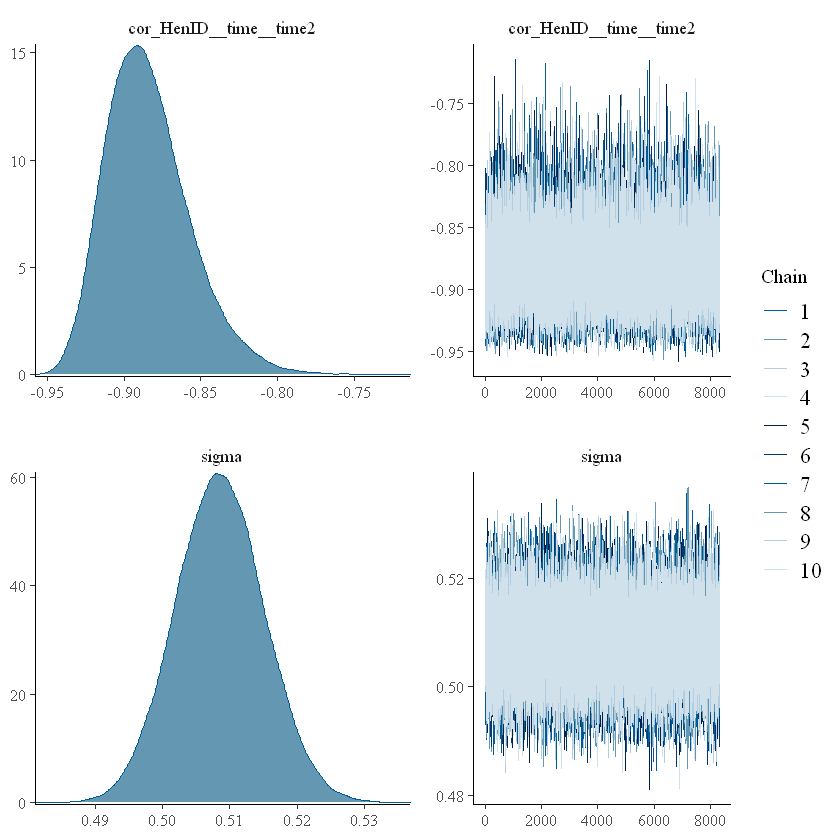

In [8]:
#double_model = bf(PC1~ time + time2 + Treatment + temperature_C_avg_scale + (1+time+time2|HenID))
double_model = bf(PC1~ time + time2 + Treatment + temperature_C_avg_scale + (1+time+time2|HenID))
modelPred2 = brm(double_model, data=df, iter=50000, inits="random", seed=12345, control = list(max_treedepth = 15), 
                cores=my.cores, chains=10, thin=3)
modelPred2 = add_criterion(modelPred2, criterion=c('waic','bayes_R2','loo'), file=file.path(path_adapt,'BRMS_Model_variance0_pred_'))
summary(modelPred2)
plot(modelPred2)

In [10]:
print(modelPred2$criteria$waic) #without sigma


Computed from 83340 by 3230 log-likelihood matrix

          Estimate    SE
elpd_waic  -2518.2  50.2
p_waic       219.3   8.9
waic        5036.4 100.3

92 (2.8%) p_waic estimates greater than 0.4. We recommend trying loo instead. 


In [11]:
print(modelPred$criteria$waic)


Computed from 83340 by 3230 log-likelihood matrix

          Estimate   SE
elpd_waic  -2214.4 47.5
p_waic       287.4 10.2
waic        4428.8 95.0

125 (3.9%) p_waic estimates greater than 0.4. We recommend trying loo instead. 


In [12]:
print(modelPred$criteria$loo)


Computed from 83340 by 3230 log-likelihood matrix

         Estimate   SE
elpd_loo  -2223.3 48.0
p_loo       296.3 11.1
looic      4446.6 95.9
------
Monte Carlo SE of elpd_loo is NA.

Pareto k diagnostic values:
                         Count Pct.    Min. n_eff
(-Inf, 0.5]   (good)     3205  99.2%   4673      
 (0.5, 0.7]   (ok)         21   0.7%   728       
   (0.7, 1]   (bad)         4   0.1%   147       
   (1, Inf)   (very bad)    0   0.0%   <NA>      
See help('pareto-k-diagnostic') for details.


In [13]:
print(modelPred2$criteria$loo) #without sigma


Computed from 83340 by 3230 log-likelihood matrix

         Estimate    SE
elpd_loo  -2522.2  50.3
p_loo       223.3   9.3
looic      5044.3 100.7
------
Monte Carlo SE of elpd_loo is NA.

Pareto k diagnostic values:
                         Count Pct.    Min. n_eff
(-Inf, 0.5]   (good)     3216  99.6%   5104      
 (0.5, 0.7]   (ok)         12   0.4%   982       
   (0.7, 1]   (bad)         2   0.1%   313       
   (1, Inf)   (very bad)    0   0.0%   <NA>      
See help('pareto-k-diagnostic') for details.


In [14]:
loo_compare(modelPred, modelPred2, criterion = "waic")

,elpd_diff,se_diff,elpd_waic,se_elpd_waic,p_waic,se_p_waic,waic,se_waic
modelPred,0.0000,0.00000,-2214.384,47.52255,287.4219,10.234760,4428.768,95.0451
modelPred2,-303.8031,25.80835,-2518.187,50.17397,219.3393,8.904353,5036.375,100.3479


In [15]:
loo_compare(modelPred, modelPred2, criterion = "loo")

,elpd_diff,se_diff,elpd_loo,se_elpd_loo,p_loo,se_p_loo,looic,se_looic
modelPred,0.0000,0.00000,-2223.307,47.95323,296.3450,11.052514,4446.614,95.90647
modelPred2,-298.8535,26.10785,-2522.161,50.34578,223.3128,9.321904,5044.322,100.69157


## on another day, after model training

In [13]:
##https://bookdown.org/marklhc/notes_bookdown/model-diagnostics.html
#additonally marginal model plots could be done with : https://github.com/marklhc/usc-psyc621-notes/blob/master/mmp_brm.R
#as explained here: https://bookdown.org/marklhc/notes_bookdown/model-diagnostics.html#diagnostic-tools

In [9]:
modelPred = readRDS(file.path(path_adapt,'BRMS_Model_variance0_pred.rds'))

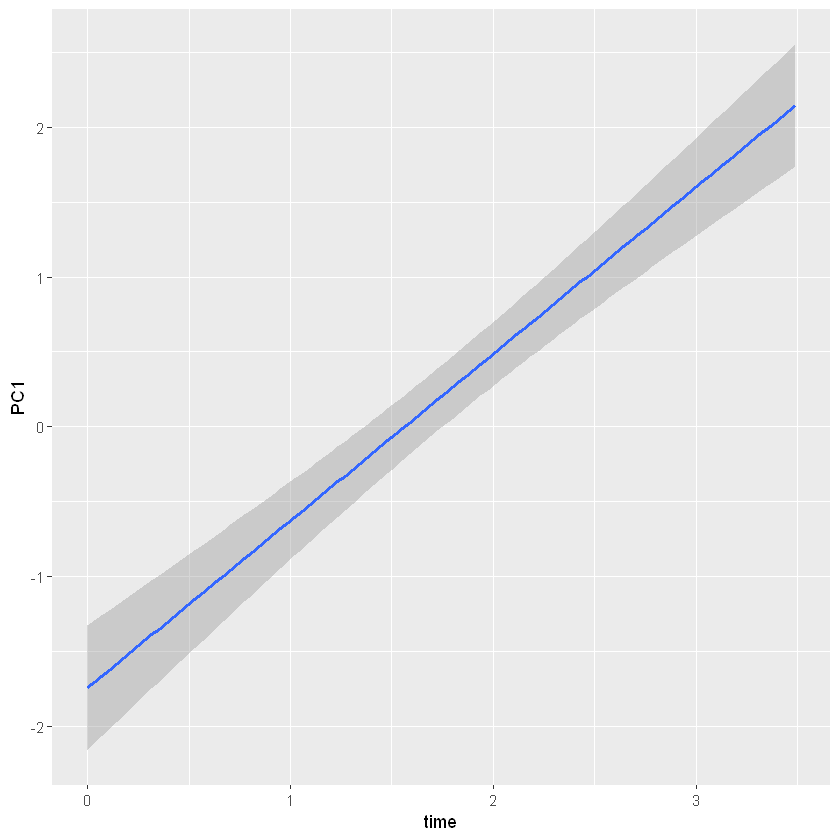

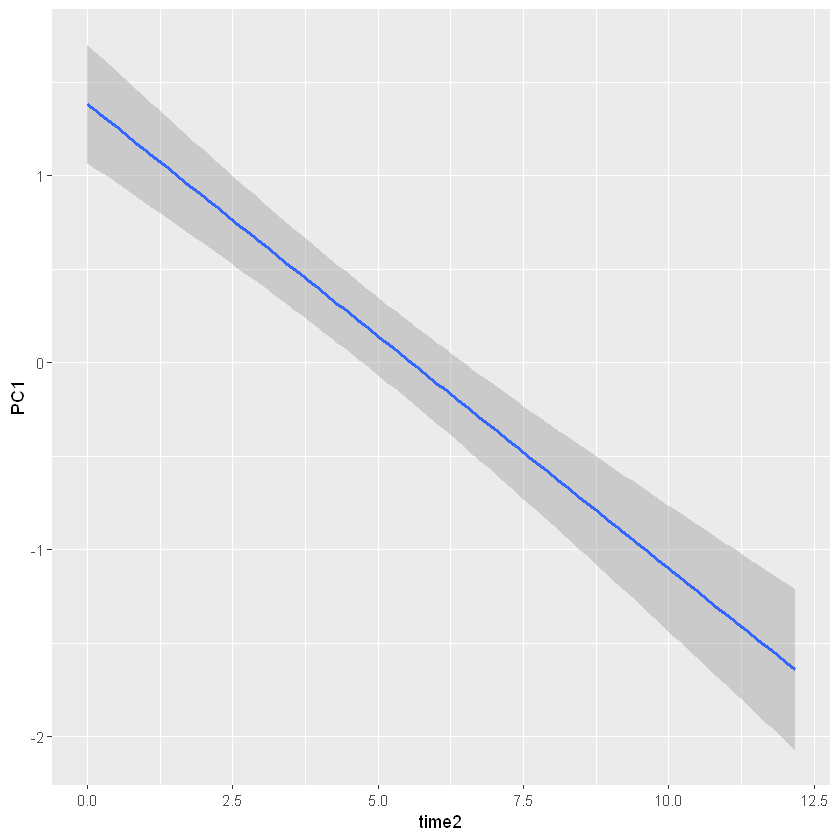

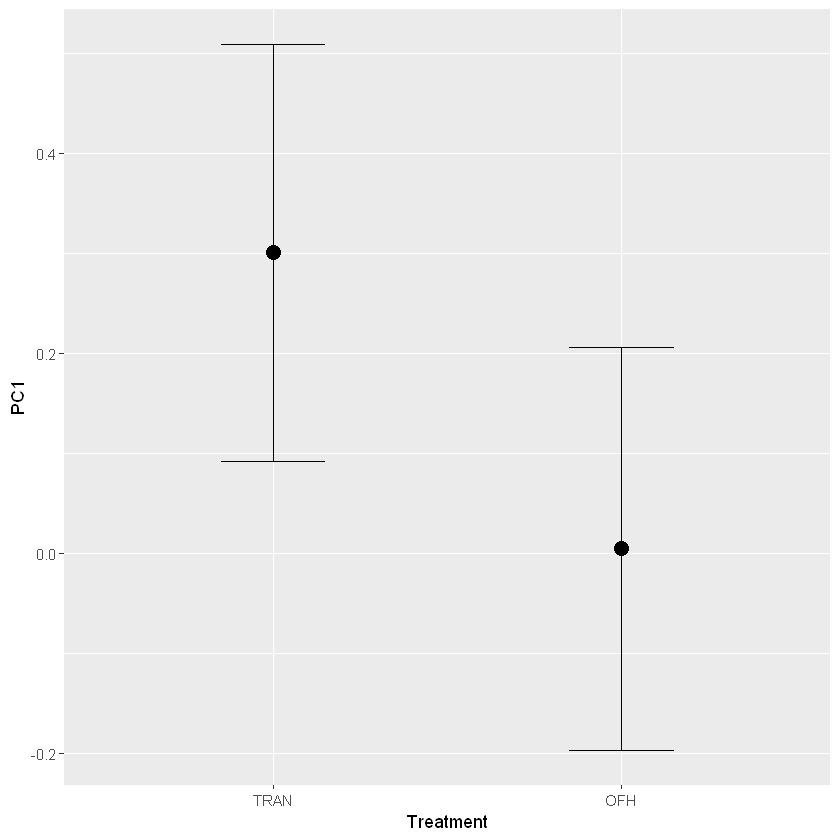

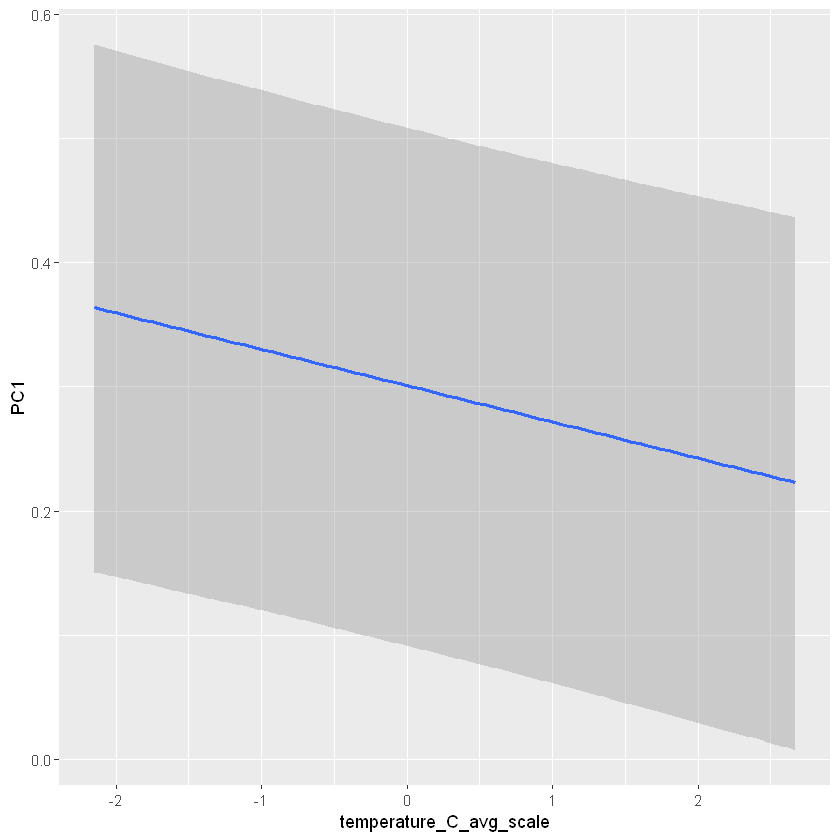

In [12]:
conditional_effects(modelPred)